In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown https://drive.google.com/uc?id=1an6F4Dvl8RPWPoOfKueSTqmzI6rmRarU



Downloading...
From: https://drive.google.com/uc?id=1an6F4Dvl8RPWPoOfKueSTqmzI6rmRarU
To: /content/CMPT_732_Dataset.zip
100% 1.26G/1.26G [00:16<00:00, 76.2MB/s]


In [3]:
!unzip -q CMPT_732_Dataset.zip

In [11]:
import numpy as np
import os
import json
import os
# class_name_to_id_mapping = {"Cow": 0,
#                 "Chicken": 1,
#                 "Sheep": 2,
#                 "Goat": 3,
#                 "Pig": 4}
class_name_to_id_mapping = {"Sam": 0,
                            "Lucy": 1,
                            "Ross": 2,
                            "Mary": 3,
                            "Elon": 4,
                            "Alex": 5,
                            "Max": 6
                            }


# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, image_file, name_file):
    print_buffer = []
    data = np.load(info_dict)
    image_w, image_h = image_file.size
    class_id = []
    with open(name_file, 'r') as info_name:
        data_name = json.load(info_name)
        for values in data_name.values():
            class_id.append(class_name_to_id_mapping[values["name"]])
        #print(class_id)

    counter = 0
    # For each bounding box
    for b in data:
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b[1] + b[3]) / 2 
        b_center_y = (b[2] + b[4]) / 2
        b_width    = (b[3] - b[1])
        b_height   = (b[4] - b[2])
        
        # Normalise the co-ordinates by the dimensions of the image


 
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id[counter], b_center_x, b_center_y, b_width, b_height))
        counter+=1
    # Name of the file which we have to save
    path_pic = "J:\CMPT 732 Project\CMPT732_data_yolov5"
    save_file_name = os.path.join(path_pic, info_dict.replace("npy", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [12]:
import os

from PIL import Image

# Convert and save the annotations
#for ann in tqdm(annotations):
#path_label = "/content/RenderProduct_Replicator/bounding_box_2d_loose"
path_pic = "J:\CMPT 732 Project\CMPT732_data_yolov5"
datanames = os.listdir(path_pic)
for i in datanames:
    if os.path.splitext(i)[1]=='.npy':
        #np.load("../"+info_dict)

        # info_dict = open(os.path.join(path_pic,i), "rb")
        info_dict = os.path.join(path_pic,i)
       
        image_file = i.replace("bounding_box_2d_loose_", "rgb_").replace("npy", "png")

        #os.listdir(path_pic)
        image_file = Image.open(os.path.join(path_pic, image_file))
        info_name = i.replace("bounding_box_2d_loose_", "bounding_box_2d_loose_labels_").replace("npy", "json")

        name_file = os.path.join(path_pic,info_name)

        convert_to_yolov5(info_dict, image_file, name_file)

annotations = [os.path.join(path_pic, x) for x in os.listdir(path_pic) if x[-3:] == "txt"]

#print(extract_info_from_npy('/content/RenderProduct_Replicator/bounding_box_2d_loose/bounding_box_2d_loose_0000.npy'))

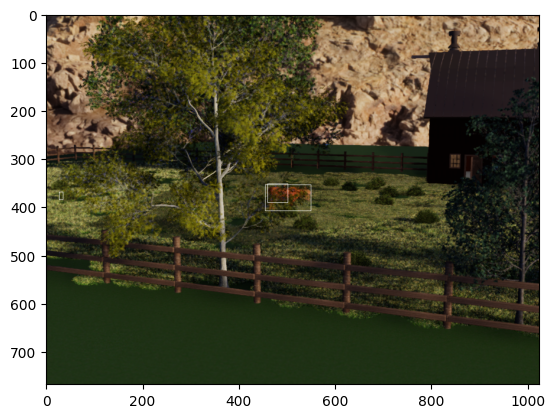

In [13]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        obj_cls_update = obj_cls.astype(np.int32)
        #print(obj_cls_update.dtype)
        
        #plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
        #plotted_image.plt((x0, y0 - 10), obj_cls.astype(np.int32))

    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)

with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("bounding_box_2d_loose_", "rgb_").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [16]:
from sklearn.model_selection import train_test_split
# Read images and annotations
images = [os.path.join(path_pic, x) for x in os.listdir(path_pic) if x[-3:] == "png"]
#print(len(images))
# datanames = os.listdir(path_pic)
annotations = [os.path.join(path_pic, x) for x in os.listdir(path_pic) if x[-3:] == "txt"]
#print(len(annotations))

images.sort()
annotations.sort()
# for i in annotations:
#     update_annotations = i.replace("bounding_box_2d_loose_", "rgb_").replace("txt", "png")
#     if update_annotations not in images:
#         print(update_annotations)

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.3, random_state = 1)

In [17]:
import os

path1 = 'J:\CMPT 732 Project\CMPT732_data_yolov5'

os.mkdir(path1+'\images')
os.mkdir(path1+'\labels')
file_name = ['/train', '/val', '/test']
path2 = 'J:\CMPT 732 Project\CMPT732_data_yolov5\images'
for name in file_name:
    os.mkdir(path2+name)
path3 = 'J:\CMPT 732 Project\CMPT732_data_yolov5\labels'
for name in file_name:
    os.mkdir(path3+name)

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'J:\\CMPT 732 Project\\CMPT732_data_yolov5\\images'

In [10]:
import shutil
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        shutil.move(f, destination_folder)

# Move the splits into their folders
move_files_to_folder(train_images, 'J:\CMPT 732 Project\CMPT732_data_yolov5/images/train/')
move_files_to_folder(val_images, 'J:\CMPT 732 Project\CMPT732_data_yolov5/images/val/')
move_files_to_folder(test_images, 'J:\CMPT 732 Project\CMPT732_data_yolov5/images/test/')
move_files_to_folder(train_annotations, 'J:\CMPT 732 Project\CMPT732_data_yolov5/labels/train/')
move_files_to_folder(val_annotations, 'J:\CMPT 732 Project\CMPT732_data_yolov5/labels/val/')
move_files_to_folder(test_annotations, 'J:\CMPT 732 Project\CMPT732_data_yolov5/labels/test/')